In [317]:
import numpy
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Metrics:

In [318]:
def precision(conf_matrix):
  TN, FP, FN, TP = conf_matrix.ravel()
  # tn, fp, fn, tp
  # TP = conf_matrix[0][0]
  # FP = conf_matrix[0][1]
  return TP/(TP+FP)

def TPR(conf_matrix):
  TN, FP, FN, TP = conf_matrix.ravel()
  # TP = conf_matrix[0][0]
  # FN = conf_matrix[1][0]
  return TP/(TP+FN)

def FPR(conf_matrix):
  TN, FP, FN, TP = conf_matrix.ravel()
  # FP = conf_matrix[0][1]
  # TN = conf_matrix[1][1]
  return FP/(FP+TN)

# TN = CM[0][0]
# FN = CM[1][0]
# TP = CM[1][1]
# FP = CM[0][1]

Get dataset and apply preprocessing

In [319]:
data_file = 'drebin-215-dataset-5560malware-9476-benign.csv'
# SOURCE: https://www.kaggle.com/datasets/shashwatwork/android-malware-dataset-for-machine-learning?select=dataset-features-categories.csv
df = pd.read_csv(data_file)
df = df[~df.eq('?').any(axis=1)]
df = df[~df.eq('unknown').any(axis=1)]

# B=Benign; S=Malware
# change categorical to numerical (1=Malware, 0=Benign)
df['class'].replace(to_replace=['S', 'B'], value=[1,0], inplace=True)

X = df.values[:,:-1].astype(float)
y = df['class'].astype('int').values


<ipython-input-319-b65a8d9c7b7b>:3: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


Get Train - Validation - Test splits

In [320]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.8*0.25 = 0.2

In [321]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_val = X_val.astype(float)

### Get predictions using a Random Forest Classifier

In [322]:
from sklearn.ensemble import RandomForestClassifier
forest  = RandomForestClassifier(max_depth=10, random_state=0, criterion='entropy')
forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=0)

In [323]:
y_pred_test_rf = forest.predict(X_test)

In [324]:
matrix_rf = confusion_matrix(y_test, y_pred_test_rf)
print(f'Random Forest: \nTPR = {"{:.3f}".format(TPR(matrix_rf))}, FPR = {"{:.3f}".format(FPR(matrix_rf))}')

Random Forest: 
TPR = 0.934, FPR = 0.012


In [325]:
from sklearn.metrics import accuracy_score

In [326]:
accuracy_score(y_test, y_pred_test_rf)

0.9680744928500167

### Get predictions using a Support Vector Machine (SVM)

In [327]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [328]:
svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf'))
svm_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [329]:
y_pred_test_svm = svm_clf.predict(X_test)
matrix_svm = confusion_matrix(y_test, y_pred_test_svm)
print(f'SVM: \nTPR = {"{:.3f}".format(TPR(matrix_svm))}, FPR = {"{:.3f}".format(FPR(matrix_svm))}')

SVM: 
TPR = 0.960, FPR = 0.006


In [330]:
accuracy_score(y_test, y_pred_test_svm)

0.981376787495843

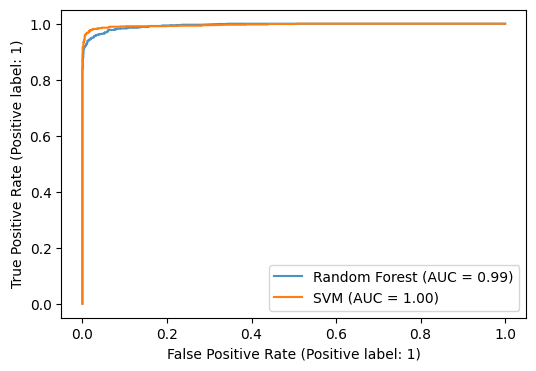

In [331]:
fig, ax = plt.subplots(figsize=(6,4))
sklearn.metrics.RocCurveDisplay.from_estimator(forest, X_test, y_test, ax=ax, alpha=0.8, name='Random Forest')
sklearn.metrics.RocCurveDisplay.from_estimator(svm_clf, X_test, y_test, ax=ax, name='SVM')

### Get predictions using a Neural Network (NN)

In [332]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [333]:
class MALWARE_CLASSIFIER(nn.Module):
  def __init__(self, n_features, dropout=0.3):
    super(MALWARE_CLASSIFIER, self).__init__()
    self.L1 = nn.Linear(n_features, 64)
    self.L2 = nn.Linear(64, 32)
    self.dropout = nn.Dropout(p=dropout)
    self.L3 = nn.Linear(32,2)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu(self.L1(x))
    x = self.sigmoid(self.L2(x))
    x = self.dropout(x)
    x = self.L3(x)

    return x
  
  def get_pred(self, X):
    '''
    Get an array of predicted labels by applying softmax to the output layer 
    and getting the class with higher activation.
    '''
    with torch.no_grad():
      outs = model(X)
      probs = F.softmax(outs, dim=1)
      y_hat = torch.argmax(probs, dim=1)
      return y_hat

  def get_acc(self, X, Y):
    with torch.no_grad():
      y_hat = self.get_pred(X)
    
      return (torch.eq(y_hat, Y).sum() / Y.shape[0]).item()

In [334]:
X_train = torch.FloatTensor(X_train)
Y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
Y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)




In [335]:
model = MALWARE_CLASSIFIER(215)
lr = 10**(-3)
momentum = 0.9
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [336]:
max_epochs = 300
batch_size = 64

print_every = 5

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, num_workers=0)

val_loader = torch.utils.data.DataLoader(X_val, batch_size=batch_size, num_workers=0)

train_losses = []
val_losses = []

val_acc = []

for epoch in range(max_epochs):
  model.train()
  running_loss = 0.0
  count = 0
  for i, data in enumerate(train_loader, 0):
    optimizer.zero_grad()

    outs = model(data)
    loss = loss_fn(outs, Y_train[i*batch_size:(i+1)*batch_size])
    running_loss += loss.item()
    count += 1
    loss.backward()
    optimizer.step()
  
  with torch.no_grad():
    val_loss = 0
    val_count = 0

    for i, data in enumerate(val_loader, 0):
      outs = model(data)
      loss = loss_fn(outs, Y_val[i*batch_size:(i+1)*batch_size])

      val_loss += loss
      val_count += 1
    
    val_acc.append(model.get_acc(X_val, Y_val))

  train_losses.append(running_loss/count)
  val_losses.append(val_loss/val_count)
  if epoch % print_every == 0:
    print(f'Epoch {epoch}: \n \t Training Loss={train_losses[-1]} Val. Loss={val_losses[-1]}')

  

Epoch 0: 
 	 Training Loss=0.6704148197850437 Val. Loss=0.6556329727172852
Epoch 5: 
 	 Training Loss=0.6472058089066904 Val. Loss=0.6344019174575806
Epoch 10: 
 	 Training Loss=0.5423468106181909 Val. Loss=0.509830892086029
Epoch 15: 
 	 Training Loss=0.31121846621340893 Val. Loss=0.29020580649375916
Epoch 20: 
 	 Training Loss=0.21369829562538906 Val. Loss=0.20448435842990875
Epoch 25: 
 	 Training Loss=0.17506921159248826 Val. Loss=0.18120649456977844
Epoch 30: 
 	 Training Loss=0.15392225819593625 Val. Loss=0.1479496955871582
Epoch 35: 
 	 Training Loss=0.13646041453941493 Val. Loss=0.12979474663734436
Epoch 40: 
 	 Training Loss=0.12424046525084381 Val. Loss=0.12214136868715286
Epoch 45: 
 	 Training Loss=0.11858761714811021 Val. Loss=0.11098146438598633
Epoch 50: 
 	 Training Loss=0.1107044398705376 Val. Loss=0.11176101118326187
Epoch 55: 
 	 Training Loss=0.10502742226929107 Val. Loss=0.09909674525260925
Epoch 60: 
 	 Training Loss=0.09974807648794025 Val. Loss=0.094871044158935

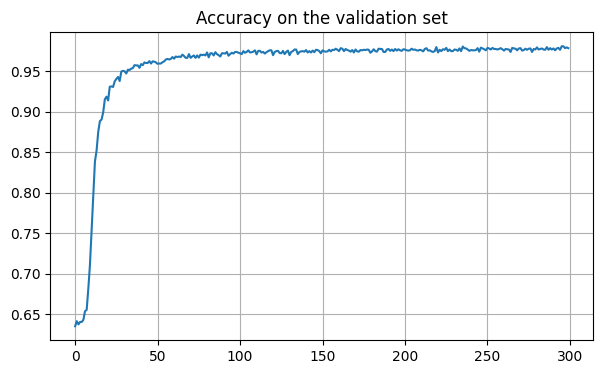

In [337]:
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(val_acc)
ax.set_title('Accuracy on the validation set')
ax.grid()
fig.show()

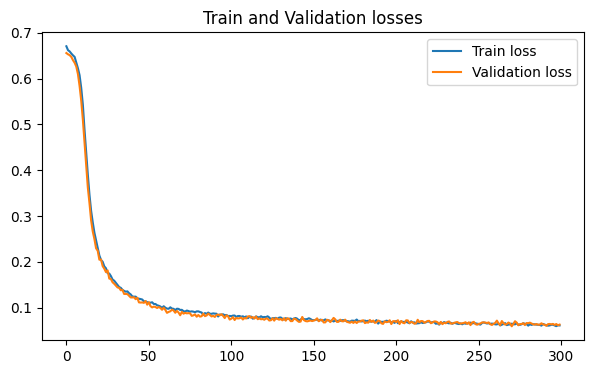

In [338]:
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(train_losses, label='Train loss')
ax.plot(val_losses, label='Validation loss')
ax.set_title('Train and Validation losses')
ax.legend()
fig.show()

In [350]:
y_hat = model.get_pred(X_test)
matrix_nn = confusion_matrix(y_test, y_hat)
print(f'Neural Network: \nTPR = {"{:.3f}".format(TPR(matrix_nn))}, FPR = {"{:.3f}".format(FPR(matrix_nn))}')

Neural Network: 
TPR = 0.964, FPR = 0.021


In [351]:
print(f'NN accuracy: {model.get_acc(X_test, y_test)}')

NN accuracy: 0.9743930697441101


# Try to trick the NN model



In [352]:
# (1=Malware, 0=Benign)
malwares = X[df['class'] == 1]
normal = X[df['class'] == 0]

Get the mean features of the malwares and the normal softwares.

Get the difference of the means. Positive values in this difference represents features that are on average more used by normal software than by malwares. We can try to trick a model by adding features to malwares (add noise to the malware behaviour while keeping its intended behaviour). Of course we can not remove features, otherwise we would change the malware behaviour.

In [353]:
malware_meanfeatures = malwares.mean(axis=0)
normal_meanfeatures = normal.mean(axis=0)
diff = normal_meanfeatures-malware_meanfeatures
th = 0.15
trick_features = diff > th

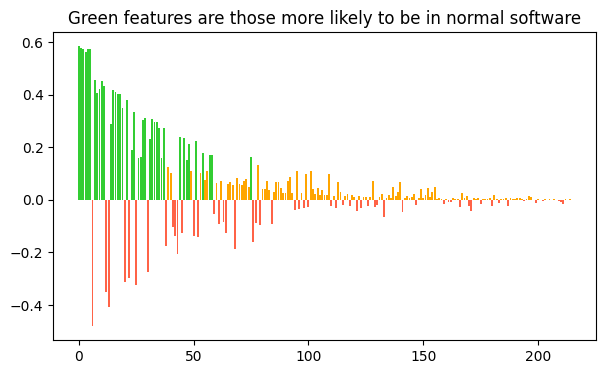

In [381]:
fig, ax = plt.subplots(figsize=(7,4))
color = [{e<0: 'tomato', 0<=e<=th: 'orange', e>th: 'limegreen'}[True] for e in diff]
ax.bar([i for i in range(len(diff))], diff, color=color)
ax.set_title('Green features are those more likely to be in normal software')
fig.show()


In [355]:
some_malware = malwares[1]
some_malware[trick_features] = 1

model.get_pred(torch.FloatTensor(some_malware.reshape(1,-1)))

tensor([0])

In [366]:
# For each malware row, add a 1 on the previously defined features
# that are more likely to be found in a normal software.
X_tricked = X_test.clone().detach()
malwares_indices = y_test == 1
for i in range(X_tricked.shape[0]):
  if not malwares_indices[i]:
    continue
  for j in range(X_tricked.shape[1]):
    if trick_features[j]:
      X_tricked[i,j] = 1


In [382]:
y_hat_tricked = model.get_pred(X_tricked)
matrix_nn = confusion_matrix(y_test, y_hat_tricked)
print(f'Neural Network with tricked values: \nTPR = {"{:.3f}".format(TPR(matrix_nn))}, FPR = {"{:.3f}".format(FPR(matrix_nn))}')

Neural Network with tricked values: 
TPR = 0.000, FPR = 0.022


In [383]:
print(f'NN accuracy with tricked values: {model.get_acc(X_tricked, y_test)}')

NN accuracy with tricked values: 0.6142334342002869


In [384]:
# Note that the accuracy corresponds to the fraction of normal softwares.
# The model is not able to recognize any malware anymore!!
y_test[y_test==0].shape[0] / y_test.shape[0]

0.627203192550715